In [ ]:
from google.colab import drive, auth
import sys
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import librosa
import matplotlib.pyplot as plt
import csv
from IPython.display import Audio
drive.mount('/content/drive')

#sklearn libraries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

#tensorflow
import tensorflow as tf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#declare sampling rate
sampling_rate = 16000

In [ ]:
#read data
bird_df = pd.read_csv('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/RG/3_species/train_val.csv')
bird_df.head(1)

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE,train


In [ ]:
#Gather the training data from the main dataset
bird_train_df = bird_df[bird_df['data'] == 'train']
bird_train_df.shape

(657, 9)

In [ ]:
#lets create a separate validation set
bird_val_df =  bird_df[bird_df['data'] == 'val']
bird_val_df.shape

(283, 9)

In [ ]:
# Group the dataframe by the "primary_label" column and calculate the total duration for each group
label_durations_train = bird_train_df.groupby('primary_label')['duration_secs_32000'].sum()

# Print the result
print(label_durations_train)

# Group the dataframe by the "primary_label" column and calculate the total duration for each group
label_durations_val = bird_val_df.groupby('primary_label')['duration_secs_32000'].sum()

# Print the result
print(label_durations_val)

primary_label
barswa     7418.617906
comsan     7488.164156
eaywag1    7235.116813
Name: duration_secs_32000, dtype: float64
primary_label
barswa     2956.129906
comsan     2823.414500
eaywag1    3083.174312
Name: duration_secs_32000, dtype: float64


In [ ]:
#get the sample count
train_class_counts = bird_train_df['primary_label'].value_counts()
val_class_counts = bird_val_df['primary_label'].value_counts()

print("Train Class Counts:")
print(train_class_counts)

print("Validation Class Counts:")
print(val_class_counts)

Train Class Counts:
comsan     244
eaywag1    216
barswa     197
Name: primary_label, dtype: int64
Validation Class Counts:
comsan     105
eaywag1     93
barswa      85
Name: primary_label, dtype: int64


In [ ]:
#Count the number of audio files that are exactly 15 seconds
num_5_sec = len(bird_train_df[bird_train_df['duration_secs_32000'] > 5])

#Count the number of audio files that are less than 15 seconds
num_less_than_5_sec = len(bird_train_df[bird_train_df['duration_secs_32000'] < 5])

print("Number of audio files that are exactly 15 seconds:", num_5_sec)
print("Number of audio files that are less than 15 seconds:", num_less_than_5_sec)

Number of audio files that are exactly 15 seconds: 417
Number of audio files that are less than 15 seconds: 240


In [ ]:
#get the audio path
audio_path = '/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/data/train/librosa_loaded/'

In [ ]:
#Function to load the loudest 5-second audio
def load_audio(file_name):
    audio = np.load(audio_path + file_name)
    return audio

In [ ]:
#chunk the audio into 5 sec frame with no overlaps
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 2.5,
      sample_rate = sampling_rate,
      ) -> np.ndarray:

    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

In [ ]:
#generate gaussian noise on one of the frames
def generate_gaussian_noise(length, mean=0, std=0.01):
    gaussian_noise = np.random.normal(mean, std, length)
    return gaussian_noise

#extract mfcc from frames
def extract_mfcc_from_frames(framed_audio, class_label, sample_rate=16000, n_mfcc=20):
  mfcc_frames = []
  target_label = []
  for frame in framed_audio:
    frame = np.array(frame)

    #Extract mfcc from the main audio frame
    mfcc = librosa.feature.mfcc(y=frame, sr=sample_rate, n_mfcc=n_mfcc)

    #Transpose the MFCC matrix
    transposed_mfcc = mfcc.T

    #lets get the mfcc
    mfcc_frames.append(transposed_mfcc)

    #Also append the class labels to target_label
    target_label.append(class_label)

  assert len(mfcc_frames) == len(target_label)
  return mfcc_frames,target_label

In [ ]:
def extract_final_features_from_dataframe(df):
    mfccs = []
    target_labels = []
    for index, row in df.iterrows():
        file_name = str(row['filename_npy'])
        class_label = row["primary_label"]
        audio = load_audio(file_name)  # Load the audio using the load_audio function
        framed_audio = frame_audio(audio)  # Frame the audio into 5-second segments
        mfcc_frames, target_label = extract_mfcc_from_frames(framed_audio, class_label, sample_rate=sampling_rate)  # Extract MFCC features for each frame
        mfccs.extend(mfcc_frames)
        target_labels.extend(target_label)
    return mfccs, target_labels

In [ ]:
#extract the mfcc embeddings from the model
mfcc_embeddings, labels = extract_final_features_from_dataframe(bird_train_df)

In [ ]:
mfcc_embeddings[:1]

[array([[-640.8579   ,   64.677185 ,  -62.988552 , ...,   -6.7448916,
           -1.0803337,   -1.5052841],
        [-367.0238   ,   61.163193 ,  -64.072556 , ...,   -6.0492578,
          -10.800379 ,   -6.3168383],
        [-292.5032   ,   58.88469  ,  -67.405975 , ...,   -2.8861198,
           -7.559266 ,   -2.872631 ],
        ...,
        [-276.97238  ,   53.687866 ,  -43.175415 , ...,   -7.3569508,
           -5.576524 ,    1.9049327],
        [-269.13995  ,   34.2004   ,  -37.430283 , ...,    3.6669822,
           -1.3040459,   -2.1778526],
        [-294.32895  ,   27.14126  ,  -45.10728  , ...,   10.434868 ,
           -0.9374119,   -4.9370155]], dtype=float32)]

In [ ]:
#verify the shapes
x_train = np.array(mfcc_embeddings)
y_train = np.array(labels)
print(x_train.shape)
print(y_train.shape)

(9203, 157, 20)
(9203,)


In [ ]:
#lets extract the embeddings
val_embeddings, val_labels = extract_final_features_from_dataframe(bird_val_df)

In [ ]:
val_embeddings[:1]

[array([[-340.6138   ,  127.00826  ,   44.271774 , ...,   10.514736 ,
           -0.6833378,   11.0607815],
        [-283.6167   ,  124.63982  ,   38.063232 , ...,   11.196489 ,
            0.567252 ,    6.3750343],
        [-275.97565  ,  124.30683  ,   34.929054 , ...,    5.1549063,
            2.2961612,    3.1506374],
        ...,
        [-255.79277  ,  143.95294  ,   43.216595 , ...,    2.4150612,
            1.5392418,   -1.5801059],
        [-256.25858  ,  140.16705  ,   39.414555 , ...,    4.858892 ,
            5.822331 ,    3.4978468],
        [-267.41135  ,  131.66406  ,   34.269558 , ...,    3.8172016,
            1.4814109,    1.075378 ]], dtype=float32)]

In [ ]:
#verify the val data shapes
x_val = np.array(val_embeddings)
y_val = np.array(val_labels)
print(x_val.shape)
print(y_val.shape)

(3687, 157, 20)
(3687,)


In [ ]:
#let us create a function to shuffle the data
def shuffle_data(x, y, random_state=1234):
    num_samples = x.shape[0]
    random_indices = np.random.RandomState(random_state).permutation(num_samples)
    x_shuffled = x[random_indices]
    y_shuffled = y[random_indices]
    return x_shuffled, y_shuffled

In [ ]:
#scale mfcc
def scale_data(data):
    # Reshape the data to 2D array
    num_samples, num_time_steps, num_features = data.shape
    data_reshaped = data.reshape(num_samples, num_features * num_time_steps)

    # Create the MinMaxScaler object and fit it to the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_reshaped)

    # Reshape the scaled data back to its original shape
    data_scaled = data_scaled.reshape(num_samples, num_time_steps, num_features)

    return data_scaled

# Example usage:
x_train_scaled = scale_data(x_train)
x_val_scaled = scale_data(x_val)
print(x_train_scaled.shape)
print(x_val_scaled.shape)

(9203, 157, 20)
(3687, 157, 20)


In [ ]:
#shuffle both train and validation sets
x_shuffled_train, y_shuffled_train = shuffle_data(x_train_scaled, y_train)
x_shuffled_val, y_shuffled_val = shuffle_data(x_val_scaled, y_val)

print(x_shuffled_train.shape)
print(y_shuffled_train.shape)

print(x_shuffled_val.shape)
print(y_shuffled_val.shape)

x_shuffled_train[:1]
x_shuffled_val[:1]

(9203, 157, 20)
(9203,)
(3687, 157, 20)
(3687,)


array([[[0.7213446 , 0.5269984 , 0.6299138 , ..., 0.30305198,
         0.56255305, 0.61029613],
        [0.70414203, 0.49735314, 0.6657116 , ..., 0.3147415 ,
         0.4717212 , 0.7715546 ],
        [0.69278884, 0.50951296, 0.7074222 , ..., 0.3087577 ,
         0.5831994 , 0.7473267 ],
        ...,
        [0.8011643 , 0.41867924, 0.62120515, ..., 0.6124097 ,
         0.52270347, 0.5217521 ],
        [0.78660053, 0.41423142, 0.6734604 , ..., 0.5273589 ,
         0.48334342, 0.55424416],
        [0.7453259 , 0.44075352, 0.6970286 , ..., 0.66646475,
         0.57439834, 0.53678745]]], dtype=float32)

Decision Tree Classifier - Decision trees and random forests in scikit-learn can handle input data (X) with multiple dimensions, including three-dimensional shapes. However, they are primarily designed for tabular data where each sample is represented by a fixed number of features (dimensions). The shape of the input data should be (n_samples, n_features).

If you have three-dimensional data, you need to reshape it into a two-dimensional format before using it with decision trees or random forests. This can be achieved by flattening or reshaping the data appropriately.

In [65]:
#reshape data to fit into decision tree
def reshape_to_2d(data):
    num_samples, time_steps, mfcc_features = data.shape
    return data.reshape(num_samples, time_steps * mfcc_features)

x_train_2d = reshape_to_2d(x_shuffled_train)
x_val_2d = reshape_to_2d(x_shuffled_val)
print(x_train_2d.shape)

(9203, 3140)


In [92]:
# Call and fit the decision tree classifier
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=15)
clf.fit(x_train_2d, y_shuffled_train)


# Predict the labels for the train data
y_pred_train = clf.predict(x_train_2d)

# Predict the labels for the validation data
y_pred = clf.predict(x_val_2d)

#Calculate and print the train accuracy
accuracy = metrics.accuracy_score(y_shuffled_train, y_pred_train)
print("train Accuracy:", accuracy)

#Calculate and print the f1 score
f1_score = metrics.f1_score(y_shuffled_train, y_pred_train, average='macro')
print("train F1 Score:", f1_score)

#Calculate and print the precision
precision = metrics.precision_score(y_shuffled_train, y_pred_train, average='macro')
print("train Precision:", precision)


#Calculate and print the val accuracy
accuracy = metrics.accuracy_score(y_shuffled_val, y_pred)
print("val Accuracy:", accuracy)

#Calculate and print the f1 score
f1_score = metrics.f1_score(y_shuffled_val, y_pred, average='macro')
print("val F1 Score:", f1_score)

#Calculate and print the precision
precision = metrics.precision_score(y_shuffled_val, y_pred, average='macro')
print("val Precision:", precision)

train Accuracy: 0.9525154840812778
train F1 Score: 0.9527895640820631
train Precision: 0.9551355606916209
val Accuracy: 0.4247355573637103
val F1 Score: 0.42439642873688815
val Precision: 0.4243497247480747


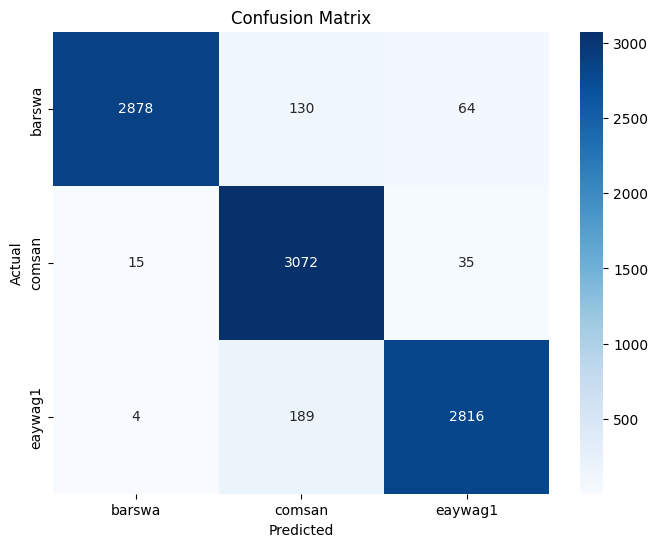

              precision    recall  f1-score   support

      barswa      0.439     0.476     0.457      1226
      comsan      0.428     0.415     0.421      1182
     eaywag1      0.406     0.385     0.396      1279

    accuracy                          0.425      3687
   macro avg      0.424     0.425     0.424      3687
weighted avg      0.424     0.425     0.424      3687



In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['barswa', 'comsan', 'eaywag1']

# Calculate and print the confusion matrix on training set
confusion_matrix = metrics.confusion_matrix(y_shuffled_train, y_pred_train)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_shuffled_val, y_pred, digits=3, zero_division='warn'))

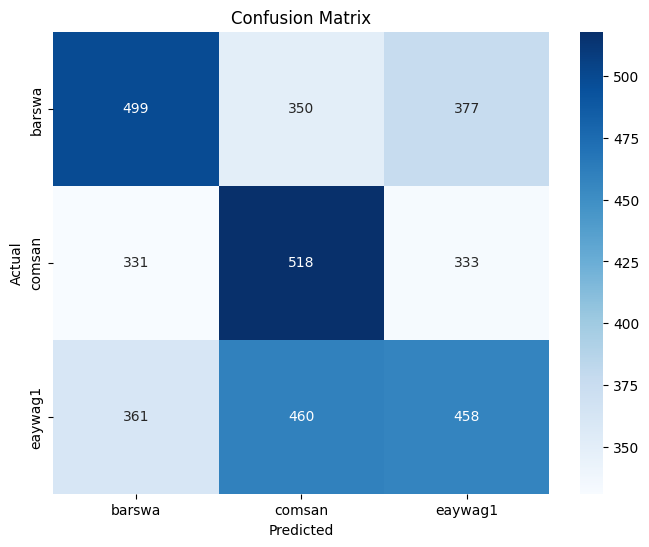

              precision    recall  f1-score   support

      barswa      0.419     0.407     0.413      1226
      comsan      0.390     0.438     0.413      1182
     eaywag1      0.392     0.358     0.374      1279

    accuracy                          0.400      3687
   macro avg      0.400     0.401     0.400      3687
weighted avg      0.400     0.400     0.399      3687



In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['barswa', 'comsan', 'eaywag1']

# Calculate and print the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_shuffled_val, y_pred)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_shuffled_val, y_pred, digits=3, zero_division='warn'))

Random Forest Classifier

In [88]:
from sklearn.ensemble import RandomForestClassifier

# Call and fit the Random Forest classifier


rf_clf = RandomForestClassifier()
rf_clf.fit(x_train_2d, y_shuffled_train)

# Predict the labels for the train data
y_pred_rf_train = rf_clf.predict(x_train_2d)

# Predict the labels for the validation data
y_pred_rf = rf_clf.predict(x_val_2d)

# Calculate and print the train accuracy
accuracy_rf = metrics.accuracy_score(y_shuffled_train, y_pred_rf_train)
print("Random Forest trsin  Accuracy:", accuracy_rf)

f1_score_rf = metrics.f1_score(y_shuffled_train, y_pred_rf_train, average='micro')
print("Random Forest train F1 Score:", f1_score_rf)

precision_rf = metrics.precision_score(y_shuffled_train, y_pred_rf_train, average='micro')
print("Random Forest train Precision:", precision_rf)

print("\n")

# Calculate and print the validation accuracy
accuracy_rf = metrics.accuracy_score(y_shuffled_val, y_pred_rf)
print("Random Forest  validation Accuracy:", accuracy_rf)

f1_score_rf = metrics.f1_score(y_shuffled_val, y_pred_rf, average='micro')
print("Random Forest validation F1 Score:", f1_score_rf)

precision_rf = metrics.precision_score(y_shuffled_val, y_pred_rf, average='micro')
print("Random Forest validation Precision:", precision_rf)

Random Forest trsin  Accuracy: 1.0
Random Forest train F1 Score: 1.0
Random Forest train Precision: 1.0
Random Forest  validation Accuracy: 0.39978302142663413
Random Forest validation F1 Score: 0.39978302142663413
Random Forest validation Precision: 0.39978302142663413


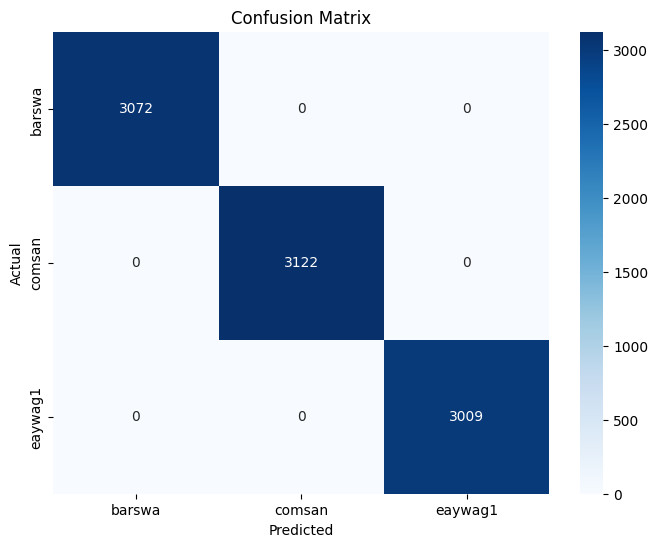

              precision    recall  f1-score   support

      barswa      1.000     1.000     1.000      3072
      comsan      1.000     1.000     1.000      3122
     eaywag1      1.000     1.000     1.000      3009

    accuracy                          1.000      9203
   macro avg      1.000     1.000     1.000      9203
weighted avg      1.000     1.000     1.000      9203



In [90]:
#train accuracy
#Define class labels
class_labels = ['barswa', 'comsan', 'eaywag1']

# Calculate and print the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_shuffled_train, y_pred_rf_train)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_shuffled_train, y_pred_rf_train, digits=3, zero_division='warn'))

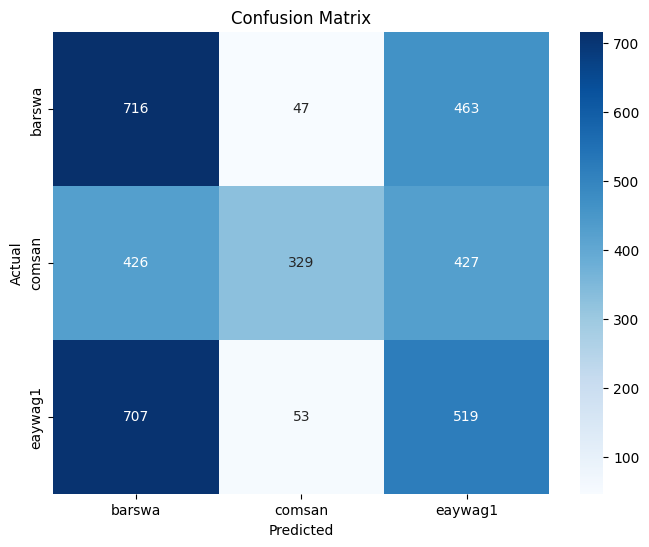

              precision    recall  f1-score   support

      barswa      0.387     0.584     0.466      1226
      comsan      0.767     0.278     0.408      1182
     eaywag1      0.368     0.406     0.386      1279

    accuracy                          0.424      3687
   macro avg      0.507     0.423     0.420      3687
weighted avg      0.502     0.424     0.420      3687



In [85]:
#validation accuracy
#Define class labels
class_labels = ['barswa', 'comsan', 'eaywag1']

# Calculate and print the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_shuffled_val, y_pred_rf)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_shuffled_val, y_pred_rf, digits=3, zero_division='warn'))